<a href="https://colab.research.google.com/github/Mazafard/BD-Landing/blob/main/Enhanced_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portuguese OCR Dataset

This notebook generates a comprehensive OCR dataset for Portuguese language with:
- Multiple books from Project Gutenberg
- Extensive font variety from Google Fonts archive
- Different backgrounds and text colors
- Complete sentences with proper punctuation
- Proper train/validation/test splits

## Install Required Packages

In [1]:
!pip install h5py numpy tqdm matplotlib scikit-learn requests pillow

## Setup Directories

In [2]:
import os
import random
import requests
import re
import math
import h5py
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont, ImageOps, ImageFilter
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from io import BytesIO
import zipfile
import glob

# Create necessary directories
os.makedirs("fonts", exist_ok=True)
os.makedirs("ocr_dataset/images", exist_ok=True)
os.makedirs("ocr_dataset/labels", exist_ok=True)
os.makedirs("previews", exist_ok=True)

print("Directories created successfully!")

Directories created successfully!


## Define Book URLs

In [3]:
# Download and process books from Project Gutenberg
book_urls = [
    "https://gutenberg.org/cache/epub/3333/pg3333.txt",      # Os Lusíadas
    "https://gutenberg.org/cache/epub/31347/pg31347.txt",    # O Guarani
    "https://gutenberg.org/cache/epub/18220/pg18220.txt",    # Portuguese book
    "https://gutenberg.org/cache/epub/32528/pg32528.txt",    # Portuguese book
    "https://gutenberg.org/cache/epub/70819/pg70819.txt",    # Portuguese book
    "https://gutenberg.org/cache/epub/37192/pg37192.txt",    # Portuguese book
    "https://gutenberg.org/cache/epub/28399/pg28399.txt",    # Portuguese book
    "https://gutenberg.org/cache/epub/142/pg142.txt",        # Portuguese book
    "https://gutenberg.org/cache/epub/31509/pg31509.txt",    # Portuguese book
    "https://gutenberg.org/cache/epub/25840/pg25840.txt",    # Portuguese book
    "https://gutenberg.org/cache/epub/55829/pg55829.txt",    # Portuguese book
    "https://gutenberg.org/cache/epub/57895/pg57895.txt"     # Portuguese book
]

print(f"Defined {len(book_urls)} book URLs")

Defined 12 book URLs


## Download and Extract Google Fonts Archive

In [4]:
# Download Google Fonts archive
font_archive_url = "https://github.com/google/fonts/archive/main.zip"
font_archive_path = "google_fonts.zip"

# Check if we already have the file to avoid re-downloading
if not os.path.exists(font_archive_path):
    print(f"Downloading Google Fonts archive from {font_archive_url}...")
    print("This might take a while as it's a large file (>100MB)...")

    try:
        response = requests.get(font_archive_url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        block_size = 1024 * 1024  # 1MB

        with open(font_archive_path, "wb") as f:
            with tqdm(total=total_size, unit='B', unit_scale=True) as pbar:
                for data in response.iter_content(block_size):
                    f.write(data)
                    pbar.update(len(data))

        print("Download complete!")
    except Exception as e:
        print(f"Error downloading font archive: {e}")
        print("Will try to use a subset of fonts instead")
else:
    print(f"Google Fonts archive already exists at {font_archive_path}")

This might take a while as it's a large file (>100MB)...


1.26GB [01:47, 11.7MB/s]

Download complete!


In [5]:
# Extract only the regular TTF files from OFL directory (open source fonts)
# to save space and processing time
if os.path.exists(font_archive_path):
    # Create a list to store paths to usable fonts
    font_paths = []

    print("Extracting usable fonts from the archive...")
    try:
        with zipfile.ZipFile(font_archive_path, 'r') as zip_ref:
            # Get all file names in the archive
            all_files = zip_ref.namelist()

            # Filter for regular TTF font files in the OFL directory
            regular_font_files = [f for f in all_files if
                                 f.endswith('.ttf') and
                                 ('fonts-main/ofl/' in f.lower()) and
                                 ('regular' in f.lower() or '/regular/' in f.lower())]

            print(f"Found {len(regular_font_files)} regular font files")

            # Extract a random subset of fonts to save space
            max_fonts = 50  # Limit to a reasonable number
            selected_fonts = random.sample(regular_font_files, min(max_fonts, len(regular_font_files)))

            print(f"Extracting {len(selected_fonts)} fonts...")
            for font_file in tqdm(selected_fonts):
                # Extract just the font filename
                font_filename = os.path.basename(font_file)
                output_path = os.path.join("fonts", font_filename)

                # Extract the font file
                with zip_ref.open(font_file) as source, open(output_path, "wb") as target:
                    target.write(source.read())

                # Add to our font paths list
                font_paths.append(output_path)
    except Exception as e:
        print(f"Error extracting fonts: {e}")
else:
    print("Font archive not found. Will use fallback fonts.")
    # If we don't have the archive, download a few individual fonts instead
    fallback_font_urls = [
        ("https://github.com/google/fonts/raw/main/ofl/lora/static/Lora-Regular.ttf", "Lora-Regular.ttf"),
        ("https://github.com/google/fonts/raw/main/ofl/sourcesanspro/SourceSansPro-Regular.ttf", "SourceSansPro-Regular.ttf"),
        ("https://github.com/google/fonts/raw/main/ofl/robotoslab/static/RobotoSlab-Regular.ttf", "RobotoSlab-Regular.ttf"),
        ("https://github.com/google/fonts/raw/main/ofl/playfairdisplay/static/PlayfairDisplay-Regular.ttf", "PlayfairDisplay-Regular.ttf"),
        ("https://github.com/google/fonts/raw/main/ofl/merriweather/Merriweather-Regular.ttf", "Merriweather-Regular.ttf")
    ]

    for url, filename in tqdm(fallback_font_urls):
        font_path = os.path.join("fonts", filename)
        try:
            response = requests.get(url)
            with open(font_path, "wb") as f:
                f.write(response.content)
            font_paths.append(font_path)
        except Exception as e:
            print(f"Failed to download {filename}: {e}")

# Check if we have any fonts
if not font_paths:
    # Look for any TTF files in fonts directory
    font_paths = glob.glob("fonts/*.ttf")

# If still no fonts, add a last fallback
if not font_paths:
    print("No fonts found. Downloading a fallback font...")
    fallback_url = "https://github.com/google/fonts/raw/main/ofl/notosans/NotoSans-Regular.ttf"
    fallback_path = os.path.join("fonts", "NotoSans-Regular.ttf")
    try:
        response = requests.get(fallback_url)
        with open(fallback_path, "wb") as f:
            f.write(response.content)
        font_paths = [fallback_path]
    except Exception as e:
        print(f"Error downloading fallback font: {e}")
        print("Will attempt to use system default font")

print(f"Total usable fonts: {len(font_paths)}")
if font_paths:
    print("Sample font files:")
    for i, font in enumerate(font_paths[:5]):
        print(f"  {i+1}. {os.path.basename(font)}")

Extracting usable fonts from the archive...
Found 1324 regular font files
Extracting 50 fonts...


100%|██████████| 50/50 [00:00<00:00, 227.19it/s]

Total usable fonts: 50
Sample font files:
  1. Lugrasimo-Regular.ttf
  2. Playball-Regular.ttf
  3. Waterfall-Regular.ttf
  4. InriaSerif-Regular.ttf
  5. Acme-Regular.ttf


## Text Processing Functions

In [6]:
def extract_text_from_gutenberg(url):
    """Download and extract text from Project Gutenberg books"""
    try:
        response = requests.get(url)
        raw_text = response.text

        # Find the start and end markers (may vary by book)
        start_markers = [
            "*** START OF THE PROJECT GUTENBERG EBOOK",
            "*** START OF THIS PROJECT GUTENBERG EBOOK",
            "***START OF THE PROJECT GUTENBERG EBOOK"
        ]
        end_markers = [
            "*** END OF THE PROJECT GUTENBERG EBOOK",
            "*** END OF THIS PROJECT GUTENBERG EBOOK",
            "***END OF THE PROJECT GUTENBERG EBOOK"
        ]

        # Find the positions of markers
        start_idx = -1
        for marker in start_markers:
            pos = raw_text.find(marker)
            if pos != -1:
                start_idx = raw_text.find("\n", pos) + 1
                break

        end_idx = -1
        for marker in end_markers:
            pos = raw_text.find(marker)
            if pos != -1:
                end_idx = pos
                break

        # Extract text between markers
        if start_idx != -1 and end_idx != -1:
            return raw_text[start_idx:end_idx].strip()
        else:
            # If markers not found, try a different approach
            # Remove header and footer (rough estimation)
            lines = raw_text.splitlines()
            if len(lines) > 500:  # Assuming the book is reasonably long
                return "\n".join(lines[100:-100])  # Skip first and last 100 lines
            return raw_text

    except Exception as e:
        print(f"Error processing {url}: {e}")
        return ""

def clean_and_extract_sentences(text):
    """Clean text and extract complete sentences with punctuation"""
    # Remove chapter headings and other non-sentence text
    cleaned_text = re.sub(r'CHAPTER [IVXLCDM]+\.?', '', text)

    # Replace multiple spaces with a single space
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)

    # Split into sentences, keeping punctuation
    sentences = re.split(r'(?<=[.!?])\s+', cleaned_text)

    # Filter valid sentences
    valid_sentences = []
    for sentence in sentences:
        sentence = sentence.strip()

        # Skip very short sentences
        if len(sentence) < 20:
            continue

        # Make sure the sentence ends with punctuation
        if not sentence[-1] in '.!?':
            continue

        # Skip sentences with too many non-Portuguese characters
        non_letter_count = sum(1 for c in sentence if not (c.isalpha() or c.isspace() or c in ',.!?;:()"\'-—–'))
        if non_letter_count / len(sentence) > 0.2:  # If more than 20% are unusual characters
            continue

        # Accept sentences of reasonable length (up to 200 characters)
        if 20 <= len(sentence) <= 200:
            valid_sentences.append(sentence)

    return valid_sentences

# Test the functions on a sample book
sample_url = book_urls[0]  # First book in the list
sample_text = extract_text_from_gutenberg(sample_url)
sample_sentences = clean_and_extract_sentences(sample_text[:20000])  # Process the first 20K chars for testing
print(f"Extracted {len(sample_sentences)} sample sentences from the beginning of the first book")
if sample_sentences:
    print("\nExample sentences:")
    for i in range(min(3, len(sample_sentences))):
        print(f"  {i+1}. {sample_sentences[i]}")

Extracted 43 sample sentences from the beginning of the first book

Example sentences:
  1. 10 Vereis amor da pátria, não movido De prémio vil, mas alto e quase eterno: Que não é prémio vil ser conhecido Por um pregão do ninho meu paterno.
  2. Ouvi: vereis o nome engrandecido Daqueles de quem sois senhor superno, E julgareis qual é mais excelente, Se ser do mundo Rei, se de til gente.
  3. Fuas, que de Homero A cítara para eles só cobiço.


## Image Generation Functions

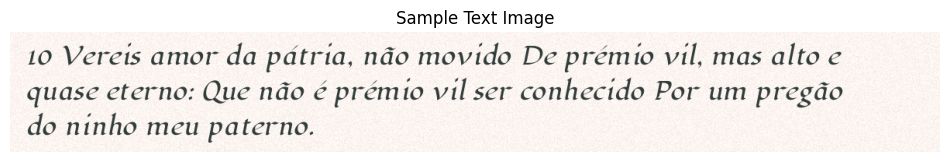

Sample text: '10 Vereis amor da pátria, não movido De prémio vil, mas alto e quase eterno: Que não é prémio vil ser conhecido Por um pregão do ninho meu paterno.'


In [7]:
def get_random_background(width=1200, height=150):
    """Generate a random background for text images"""
    background_type = random.choice(['solid', 'gradient', 'noise', 'pattern'])

    if background_type == 'solid':
        # Light solid color
        color = (random.randint(220, 255), random.randint(220, 255), random.randint(220, 255))
        img = Image.new("RGB", (width, height), color=color)

    elif background_type == 'gradient':
        # Gradient background (light)
        start_color = (random.randint(240, 255), random.randint(240, 255), random.randint(240, 255))
        end_color = (random.randint(200, 240), random.randint(200, 240), random.randint(200, 240))

        img = Image.new("RGB", (width, height), color=start_color)
        draw = ImageDraw.Draw(img)

        for y in range(height):
            r = int(start_color[0] + (end_color[0] - start_color[0]) * y / height)
            g = int(start_color[1] + (end_color[1] - start_color[1]) * y / height)
            b = int(start_color[2] + (end_color[2] - start_color[2]) * y / height)
            draw.line([(0, y), (width, y)], fill=(r, g, b))

    elif background_type == 'noise':
        # Noise background (light)
        base_color = (random.randint(240, 255), random.randint(240, 255), random.randint(240, 255))
        img = Image.new("RGB", (width, height), color=base_color)
        pixels = img.load()

        for i in range(width):
            for j in range(height):
                noise = random.randint(-10, 10)
                r = max(0, min(255, base_color[0] + noise))
                g = max(0, min(255, base_color[1] + noise))
                b = max(0, min(255, base_color[2] + noise))
                pixels[i, j] = (r, g, b)

    else:  # pattern
        # Simple pattern background (light)
        img = Image.new("RGB", (width, height), color=(255, 255, 255))
        draw = ImageDraw.Draw(img)

        pattern_type = random.choice(['dots', 'lines', 'grid'])

        if pattern_type == 'dots':
            for _ in range(500):
                x = random.randint(0, width)
                y = random.randint(0, height)
                radius = random.randint(1, 2)
                color = (random.randint(200, 240), random.randint(200, 240), random.randint(200, 240))
                draw.ellipse((x-radius, y-radius, x+radius, y+radius), fill=color)

        elif pattern_type == 'lines':
            for _ in range(20):
                x1 = random.randint(0, width)
                y1 = random.randint(0, height)
                x2 = random.randint(0, width)
                y2 = random.randint(0, height)
                color = (random.randint(200, 240), random.randint(200, 240), random.randint(200, 240))
                draw.line((x1, y1, x2, y2), fill=color, width=1)

        else:  # grid
            for x in range(0, width, 10):
                color = (random.randint(220, 240), random.randint(220, 240), random.randint(220, 240))
                draw.line((x, 0, x, height), fill=color, width=1)
            for y in range(0, height, 10):
                color = (random.randint(220, 240), random.randint(220, 240), random.randint(220, 240))
                draw.line((0, y, width, y), fill=color, width=1)

    # Occasionally add a slight blur
    if random.random() < 0.3:
        img = img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.2, 0.5)))

    return img

def create_text_image(text, font_path, width=1200, height=150):
    """Create an image with the given text and various transformations"""
    # Generate background
    img = get_random_background(width, height)

    # Create a draw object
    draw = ImageDraw.Draw(img)

    # Random font size
    font_size = random.randint(30, 45)

    # Try to load font
    try:
        font = ImageFont.truetype(font_path, size=font_size)
    except Exception as e:
        print(f"Error loading font {font_path}: {e}")
        # Use default font
        font = ImageFont.load_default()

    # Random text color (mostly dark for readability)
    text_color = (random.randint(0, 60), random.randint(0, 60), random.randint(0, 60))

    # Get text size - handle different PIL versions
    try:
        # For newer PIL versions (9.0.0+)
        text_bbox = draw.textbbox((0, 0), text, font=font)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]
    except AttributeError:
        # For older PIL versions
        text_width, text_height = draw.textsize(text, font=font)

    # If text too long, wrap it to multiple lines
    if text_width > width - 40:
        # Rough character count that would fit on one line
        chars_per_line = int((width - 40) / (text_width / len(text))) - 5  # Subtract a little for safety

        # Very simple wrapping - split into roughly equal chunks at spaces
        words = text.split()
        lines = []
        current_line = []
        current_length = 0

        for word in words:
            if current_length + len(word) + 1 <= chars_per_line:  # +1 for space
                current_line.append(word)
                current_length += len(word) + 1
            else:
                if current_line:  # If we have words in the current line
                    lines.append(' '.join(current_line))
                current_line = [word]
                current_length = len(word)

        # Add the last line if not empty
        if current_line:
            lines.append(' '.join(current_line))

        # If we have multiple lines, adjust height if needed
        if len(lines) > 1:
            required_height = len(lines) * (text_height + 5)  # 5 pixels padding between lines
            if required_height > height - 20:  # If lines don't fit
                # Create a new, taller image
                new_height = required_height + 20  # Add some margin
                img = get_random_background(width, new_height)
                draw = ImageDraw.Draw(img)
                height = new_height

        # Position for multi-line text
        x = 20
        y = max(10, (height - (len(lines) * (text_height + 5))) // 2)  # Center vertically

        # Draw each line
        for line in lines:
            draw.text((x, y), line, fill=text_color, font=font)
            y += text_height + 5  # Move down for next line
    else:
        # Single line text, can center it
        x = max(10, (width - text_width) // 2)  # Center horizontally
        y = max(10, (height - text_height) // 2)  # Center vertically

        # Occasionally add slight rotation
        if random.random() < 0.2:
            angle = random.uniform(-2, 2)  # Very slight angles for readability
            img = img.rotate(angle, resample=Image.BICUBIC, expand=False)
            draw = ImageDraw.Draw(img)

        # Draw the text
        draw.text((x, y), text, fill=text_color, font=font)

    # Occasionally add slight noise
    if random.random() < 0.2:
        # Add some noise
        pixels = img.load()
        for i in range(width):
            for j in range(height):
                if random.random() < 0.01:  # 1% of pixels
                    pixels[i, j] = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

    return img, text

# Test the image generation with a sample sentence
if sample_sentences and font_paths:
    sample_text = sample_sentences[0]
    sample_font = font_paths[0] if font_paths else None

    if sample_font:
        try:
            sample_img, _ = create_text_image(sample_text, sample_font)
            plt.figure(figsize=(12, 3))
            plt.imshow(sample_img)
            plt.axis('off')
            plt.title('Sample Text Image')
            plt.show()
            print(f"Sample text: '{sample_text}'")
        except Exception as e:
            print(f"Error generating sample image: {e}")

## Process Books and Extract Sentences

In [8]:
print("Downloading and processing books...")
all_sentences = []
for url in tqdm(book_urls):
    print(f"Processing {url}...")
    text = extract_text_from_gutenberg(url)
    sentences = clean_and_extract_sentences(text)
    all_sentences.extend(sentences)
    print(f"  - Extracted {len(sentences)} sentences")

print(f"\nExtracted {len(all_sentences)} valid sentences from all books")

# Remove duplicates
all_sentences = list(set(all_sentences))
print(f"After removing duplicates: {len(all_sentences)} sentences")

# Display the first few sentences
print("\nSample sentences:")
for i in range(min(5, len(all_sentences))):
    print(f"  {i+1}. {all_sentences[i]}")

# Save sentences to a text file for reference
with open("all_sentences.txt", "w", encoding="utf-8") as f:
    for sentence in all_sentences:
        f.write(sentence + "\n")
print("\nSaved all sentences to 'all_sentences.txt'")

  0%|          | 0/12 [00:00<?, ?it/s]

Processing https://gutenberg.org/cache/epub/3333/pg3333.txt...


  8%|▊         | 1/12 [00:01<00:20,  1.88s/it]

  - Extracted 1202 sentences
Processing https://gutenberg.org/cache/epub/31347/pg31347.txt...


 17%|█▋        | 2/12 [00:03<00:18,  1.89s/it]

  - Extracted 2568 sentences
Processing https://gutenberg.org/cache/epub/18220/pg18220.txt...


 25%|██▌       | 3/12 [00:05<00:16,  1.87s/it]

  - Extracted 3134 sentences
Processing https://gutenberg.org/cache/epub/32528/pg32528.txt...


 33%|███▎      | 4/12 [00:08<00:16,  2.09s/it]

  - Extracted 3785 sentences
Processing https://gutenberg.org/cache/epub/70819/pg70819.txt...


 42%|████▏     | 5/12 [00:09<00:14,  2.02s/it]

  - Extracted 3804 sentences
Processing https://gutenberg.org/cache/epub/37192/pg37192.txt...


 50%|█████     | 6/12 [00:11<00:11,  1.97s/it]

  - Extracted 3601 sentences
Processing https://gutenberg.org/cache/epub/28399/pg28399.txt...


 58%|█████▊    | 7/12 [00:13<00:09,  1.93s/it]

  - Extracted 2989 sentences
Processing https://gutenberg.org/cache/epub/142/pg142.txt...


 67%|██████▋   | 8/12 [00:15<00:07,  1.95s/it]

  - Extracted 3232 sentences
Processing https://gutenberg.org/cache/epub/31509/pg31509.txt...


 75%|███████▌  | 9/12 [00:17<00:06,  2.01s/it]

  - Extracted 3008 sentences
Processing https://gutenberg.org/cache/epub/25840/pg25840.txt...


 83%|████████▎ | 10/12 [00:19<00:03,  1.82s/it]

  - Extracted 1002 sentences
Processing https://gutenberg.org/cache/epub/55829/pg55829.txt...


 92%|█████████▏| 11/12 [00:21<00:01,  1.94s/it]

  - Extracted 3626 sentences
Processing https://gutenberg.org/cache/epub/57895/pg57895.txt...


100%|██████████| 12/12 [00:23<00:00,  1.96s/it]

  - Extracted 7878 sentences

Extracted 39829 valid sentences from all books
After removing duplicates: 39644 sentences

Sample sentences:
  1. The seasons when these seas are safely navigable, are now perfectly known.
  2. Huxtix, que mao lambaz.
  3. They arrived, at last, at a village inhabited by African banditti.
  4. Chegava a observar o somno.
  5. Han renegado la fè de las trobas Castellanas, y tras las Italianas se pierden, diziendo, que son mas ricas y galanas.

Saved all sentences to 'all_sentences.txt'


## Dataset Generation Functions

In [9]:
def save_to_hdf5(images, texts, filename):
    """Save images and texts to HDF5 file"""
    print(f"Saving {len(images)} samples to {filename}...")
    with h5py.File(filename, 'w') as f:
        f.create_dataset('images', data=images, compression="gzip", compression_opts=9)
        dt = h5py.special_dtype(vlen=str)
        f.create_dataset('texts', data=texts, dtype=dt)
    print(f"Saved {filename}")

def display_dataset_stats(texts):
    """Display statistics about the dataset"""
    print("\nDataset Statistics:")
    print(f"Total samples: {len(texts)}")

    # Calculate average text length
    avg_length = sum(len(t) for t in texts) / max(1, len(texts))
    print(f"Average text length: {avg_length:.2f} characters")

    # Find shortest and longest text
    if texts:
        shortest = min(texts, key=len)
        longest = max(texts, key=len)
        print(f"Shortest text ({len(shortest)} chars): {shortest[:50]}{'...' if len(shortest) > 50 else ''}")
        print(f"Longest text ({len(longest)} chars): {longest[:50]}{'...' if len(longest) > 50 else ''}")

    # Count unique characters
    if texts:
        unique_chars = set("".join(texts))
        print(f"Unique characters: {len(unique_chars)}")
        print("Character set:", "".join(sorted(unique_chars)))

        # Generate character distribution
        char_counter = Counter("".join(texts))
        top_chars = char_counter.most_common(30)
        chars, counts = zip(*[(c if c.isalpha() or c in " .,?!" else f"'{ord(c)}'", n) for c, n in top_chars])

        plt.figure(figsize=(15, 5))
        plt.bar(chars, counts)
        plt.title("Top 30 Characters in Dataset")
        plt.ylabel("Frequency")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig("char_distribution.png")
        plt.show()

## Generate Images

This cell generates the image dataset. You can adjust the number of samples to generate.

In [ ]:
# Set the number of samples to generate
num_samples = 20000  # Adjust this as needed

# Check if we have enough fonts and sentences
if not font_paths:
    print("Error: No fonts available. Cannot generate images.")
elif not all_sentences:
    print("Error: No sentences extracted. Cannot generate images.")
else:
    # If we have fewer sentences than requested samples, some will be repeated
    if len(all_sentences) < num_samples:
        print(f"Warning: You requested {num_samples} samples but only have {len(all_sentences)} unique sentences.")
        print("Some sentences will be repeated with different visual styles.")

    print(f"Generating {num_samples} images using {len(font_paths)} different fonts...")
    images = []
    texts = []

    font_usage_count = {}

    for i in tqdm(range(num_samples)):
        # Select a random sentence
        sentence = random.choice(all_sentences)

        # Select a random font, track usage for variety
        font_path = random.choice(font_paths)
        font_name = os.path.basename(font_path)
        font_usage_count[font_name] = font_usage_count.get(font_name, 0) + 1

        try:
            # Create image with text
            img, text = create_text_image(sentence, font_path)

            # Save individual image and label
            img_path = f"ocr_dataset/images/sample_{i:05d}.png"
            label_path = f"ocr_dataset/labels/sample_{i:05d}.txt"

            img.save(img_path)
            with open(label_path, "w", encoding="utf-8") as f:
                f.write(text)

            # Convert to numpy array for batch saving
            img_array = np.array(img)
            images.append(img_array)
            texts.append(text)

            # Save a preview of every 1000th image
            if i % 1000 == 0:
                preview_path = f"previews/preview_sample_{i}.png"
                img.save(preview_path)
                if i % 5000 == 0 and i > 0:
                    print(f"Generated {i} images so far...")
        except Exception as e:
            print(f"Error generating image {i}: {e}")
            continue

    # Convert to numpy arrays
    images = np.array(images)
    texts = np.array(texts)

    # Print font usage statistics
    print("\nFont usage statistics:")
    top_fonts = sorted(font_usage_count.items(), key=lambda x: x[1], reverse=True)[:10]
    for font, count in top_fonts:
        print(f"  {font}: {count} images ({count/num_samples*100:.1f}%)")

    print(f"\nGenerated {len(images)} text images with corresponding labels")

Generating 20000 images using 50 different fonts...


 25%|██▌       | 5001/20000 [11:25<35:32,  7.03it/s]

Generated 5000 images so far...


 25%|██▌       | 5071/20000 [11:38<40:05,  6.21it/s]

## Split and Save Dataset

In [ ]:
# Make sure we have images to save
if 'images' not in locals() or len(images) == 0:
    print("Error: No images were generated. Cannot save dataset.")
else:
    # Split into train/val/test
    print("Splitting into train/validation/test sets...")
    X_temp, X_test, y_temp, y_test = train_test_split(images, texts, test_size=0.1, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)

    print(f"Train set: {len(X_train)} samples")
    print(f"Validation set: {len(X_val)} samples")
    print(f"Test set: {len(X_test)} samples")

    # Save datasets to HDF5 files
    save_to_hdf5(X_train, y_train, 'train_dataset.h5')
    save_to_hdf5(X_val, y_val, 'val_dataset.h5')
    save_to_hdf5(X_test, y_test, 'test_dataset.h5')

    # Also save a combined dataset
    save_to_hdf5(images, texts, 'full_dataset.h5')

    print("Dataset generation complete!")

## Display Dataset Statistics

In [ ]:
# Display dataset statistics and visualize character distribution
if 'texts' in locals() and len(texts) > 0:
    display_dataset_stats(texts)
else:
    print("No texts were generated to analyze.")

## Dataset Visualization

Display a few random samples from the dataset to verify quality

In [ ]:
# Display some random samples from the dataset
if 'images' in locals() and len(images) > 0:
    n_samples = 5
    plt.figure(figsize=(15, 4*n_samples))

    indices = np.random.choice(len(images), min(n_samples, len(images)), replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(n_samples, 1, i+1)
        plt.imshow(images[idx])
        plt.title(f"Sample {idx}: {texts[idx]}")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig("dataset_samples.png")
    plt.show()
else:
    print("No images to visualize.")

## Inspect HDF5 Files

In [ ]:
# Verify the HDF5 files
def inspect_hdf5(filename):
    print(f"\nInspecting {filename}:")
    try:
        with h5py.File(filename, "r") as f:
            print("Keys:", list(f.keys()))
            print("Images shape:", f["images"].shape)
            print("Number of samples:", len(f["texts"]))
            if len(f["texts"]) > 0:
                idx = random.randint(0, len(f["texts"]) - 1)
                text = f["texts"][idx]
                if isinstance(text, bytes):
                    text = text.decode('utf-8')
                print(f"Random sample {idx} text: '{text}'")
    except Exception as e:
        print(f"Error inspecting {filename}: {e}")

# Inspect all generated files
for filename in ['train_dataset.h5', 'val_dataset.h5', 'test_dataset.h5', 'full_dataset.h5']:
    if os.path.exists(filename):
        inspect_hdf5(filename)

##
Upload Dataset to Hugging Face

If you want to upload the dataset to Hugging Face for easy sharing and use, run the cells below.

In [ ]:
# Install Hugging Face Hub library
!pip install huggingface_hub

In [ ]:
# To upload to Hugging Face Hub, you need to add your API token
# If running in Colab, you can set this as a user secret
from huggingface_hub import login

# If using Google Colab user secrets
try:
    from google.colab import userdata
    api_token = userdata.get('HUGGINGFACE_API_TOKEN')
    if api_token:
        login(api_token)
        print("Logged in to Hugging Face Hub using stored API token")
    else:
        print("No API token found in user secrets. Please enter your token below.")
        login()
except ImportError:
    # If not in Colab or userdata not available
    print("Please enter your Hugging Face API token when prompted")
    login()

In [ ]:
from huggingface_hub import create_repo, upload_file

# Set your Hugging Face username and repository name
hf_username = "mazafard"  # Replace with your Hugging Face username
repo_name = f"{hf_username}/portuguese_ocr_enhanced_dataset"

# Create the repository
try:
    create_repo(repo_id=repo_name, repo_type="dataset", exist_ok=True)
    print(f"Created or accessed repository: {repo_name}")
except Exception as e:
    print(f"Error creating repository: {e}")
    print("Continuing with local files only...")

In [ ]:
# Upload the dataset files
try:
    # Upload each HDF5 file
    for filename in ['train_dataset.h5', 'val_dataset.h5', 'test_dataset.h5', 'full_dataset.h5']:
        if os.path.exists(filename):
            print(f"Uploading {filename}...")
            upload_file(
                path_or_fileobj=filename,
                path_in_repo=filename,
                repo_id=repo_name,
                repo_type="dataset"
            )
            print(f"Successfully uploaded {filename}")

    # Upload preview images
    for filename in ["char_distribution.png", "dataset_samples.png"]:
        if os.path.exists(filename):
            print(f"Uploading {filename}...")
            upload_file(
                path_or_fileobj=filename,
                path_in_repo=filename,
                repo_id=repo_name,
                repo_type="dataset"
            )

    # Create a simple README markdown file
    try:
        font_count = len(font_paths) if 'font_paths' in locals() else "multiple"
        readme_content = f"""# Enhanced Portuguese OCR Dataset

This dataset contains {len(images) if 'images' in locals() else 'many'} text images for OCR training, created from Portuguese books from Project Gutenberg.

## Dataset Characteristics

- **Number of fonts:** {font_count}
- **Image size:** 1200x150 pixels (or larger for longer texts)
- **Text source:** Multiple Portuguese books from Project Gutenberg
- **Font variations:** Multiple fonts from Google Fonts collection
- **Background variations:** Solid colors, gradients, patterns, noise
- **Text transformations:** Random positioning, slight rotation, occasional noise

## Files

- `train_dataset.h5`: Training set
- `val_dataset.h5`: Validation set
- `test_dataset.h5`: Test set
- `full_dataset.h5`: Combined dataset
- `char_distribution.png`: Character distribution visualization
- `dataset_samples.png`: Sample images from the dataset

## Usage

```python
import h5py
from PIL import Image
import numpy as np
import io

# Load the dataset
with h5py.File('train_dataset.h5', 'r') as f:
    images = f['images'][:]
    texts = [t.decode('utf-8') if isinstance(t, bytes) else t for t in f['texts'][:]]
```

## Dataset Creation

This dataset was created using a custom script that extracts complete sentences with punctuation from Portuguese books and renders them using various fonts from the Google Fonts collection on different backgrounds.
"""
    except Exception as e:
        # Fallback README if variables are not defined
        readme_content = """# Enhanced Portuguese OCR Dataset

This dataset contains text images for OCR training, created from Portuguese books from Project Gutenberg.

## Dataset Characteristics

- **Image size:** 1200x150 pixels (or larger for longer texts)
- **Text source:** Multiple Portuguese books from Project Gutenberg
- **Font variations:** Multiple fonts from Google Fonts collection
- **Background variations:** Solid colors, gradients, patterns, noise
- **Text transformations:** Random positioning, slight rotation, occasional noise

## Files

- `train_dataset.h5`: Training set
- `val_dataset.h5`: Validation set
- `test_dataset.h5`: Test set
- `full_dataset.h5`: Combined dataset
- `char_distribution.png`: Character distribution visualization
- `dataset_samples.png`: Sample images from the dataset
"""

    # Write README to a file
    with open("README.md", "w", encoding="utf-8") as f:
        f.write(readme_content)

    # Upload README
    upload_file(
        path_or_fileobj="README.md",
        path_in_repo="README.md",
        repo_id=repo_name,
        repo_type="dataset"
    )

    print(f"\nAll files uploaded successfully to {repo_name}")
    print(f"View your dataset at: https://huggingface.co/datasets/{repo_name}")

except Exception as e:
    print(f"Error uploading files: {e}")
    print("Dataset files are still available locally.")

## Cleanup

If you want to clean up large files to save space, you can run this cell:

In [ ]:
# Remove the large Google Fonts archive file to save space
if os.path.exists(font_archive_path):
    print(f"Removing large font archive file: {font_archive_path}")
    os.remove(font_archive_path)
    print("Font archive removed.")

# Note: We don't remove the HDF5 files as they are your dataset output
print("Cleanup complete!")